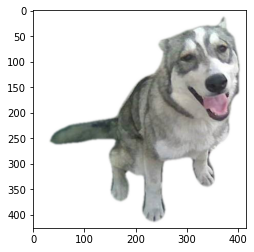

In [2]:
# 결과 폴더 저장 및 배경 흰색으로 변경

import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

image_path = '/content/drive/MyDrive/LimnPet_project/data/real/7500_9999/dog.7603.jpg'

# segmentation
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(int)[:, :3].tolist()
np.random.seed(3)
# np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # background color must be black
colors = np.array(colors, dtype=np.uint8)
# palette_map = np.empty((10, 0, 3), dtype=np.uint8)
# legend = []
# for i in range(21):
#     legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
#     c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
#     palette_map = np.concatenate([palette_map, c], axis=1)

# segmentation 함수 정의
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 

    r = PIL.Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

# 이미지 segmentation 및 결과 확인
img = np.array(PIL.Image.open(image_path))
fg_h, fg_w, _ = img.shape
segment_map, pred = segment(model, img)
background = np.ones((fg_h, fg_w, 3))*255.0
mask = (pred == 12).astype(float) * 255 # 12: dog
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)
alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)
foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  
result = cv2.add(foreground, background).astype(np.uint8)
plt.imshow(result)